In [1]:
import sklearn.base as skbase
import sklearn.pipeline as skpipe
import functools
import dask.dataframe as dd
import datetime
import numpy as np

from abc import ABC, abstractmethod
from typing import List, Dict

from dask.diagnostics import ProgressBar
ProgressBar().register()

# DaskFeatureLib

In [2]:
class Engine:
    """Emulates connection to a data base."""

    def __init__(self, tables: Dict[str, dd.DataFrame]):
        self.tables = tables

    def register_table(self, table: dd.DataFrame, name: str) -> None:
        """Add a table to available tables."""
        self.tables[name] = table

    def get_table(self, name: str) -> dd.DataFrame:
        """Return requested table."""
        return self.tables[name]

    
class BaseProcessorReference(ABC):
    def __init__(self):
        self.REFERENCE = {}

    def register(self, processor_class) -> None:
        """Add a calcer class to registry."""
        self.REFERENCE[processor_class.name] = processor_class

    def create(self, name: str, **kwargs):
        """Creates a specified calcer class with specific parameters."""
        return self.REFERENCE[name](**kwargs)

    @abstractmethod
    def compute(self, engine: Engine, features_config: dict) -> dd.DataFrame:
        pass


class BaseProcessor(ABC):
    name = "_base"

    def __init__(self, engine: Engine, data = None):
        self.engine = engine
        self.data = data

    @abstractmethod
    def compute(self):
        pass

In [3]:
"""
=== FILTER ===
Filter a dataset by row or column.
"""


class TableFilter(BaseProcessor):
    def __init__(self, type_: str, table: str, **kwargs):
        self.type = type_
        self.table = table
        super().__init__(**kwargs)  #engine, data(optional)


class FilterReference(BaseProcessorReference):
    def __init__(self, **kwargs):
        self.row_filters = list()
        self.column_filters = list()
        self.table = None
        super().__init__(**kwargs)

    def compute(self, engine: Engine, features_config: dict) -> dd.DataFrame:
        """Filter a single table using row and column filters.
        Possible row_filters: NaN, outlier, value filters.
        Possible column filters: feature selectors, drop columns.
        """

        # Initialize all filters form config:
        for feature_config in features_config:
            filter_args = feature_config["args"]  # feature params
            filter_args["engine"] = engine  # DataBase to connect to
            
            # Create filter:
            filter_ = self.create(feature_config["name"], **filter_args)
            if self.table is None:  # The first filter defines the table to be used.
                self.table = filter_.table
            else:  # Check if own table, matches the table to be used.
                assert (
                    filter_.table == self.table
                ), f"Filters should reference the same table. Current table: {self.table},\
                    but filter {filter.name} references {filter.table}."
            
            # Add filter to the row_ or column_filter list:
            assert filter_.type in {"row", "column"}, "Filter type must be 'row' or 'column'"
            if filter_.type == "row":
                self.row_filters.append(filter_)
            else:
                self.column_filters.append(filter_)

        # Use filters from the lists to create row/column masks:          
        row_mask, column_mask = None, None
        
        if any(self.row_filters):
            row_mask = self.row_filters[0].compute()
            for filter_ in self.row_filters[1:]:
                row_mask = row_mask & filter_.compute()
            #row_mask = row_mask.compute()
            
        if any(self.column_filters):
            column_mask = self.column_filters[0].compute()
            for filter_ in self.column_filters:
                column_mask = column_mask & filter_.compute()
            #column_mask = column_mask.compute()
            
        # Filter results:
        # result = engine.get_table(self.table).loc(raw_mask, column_mask)
        return row_mask, column_mask

In [4]:
"""
=== PREPROCESSOR ===
Modify existing columns.
"""


class FeatureProcessor(BaseProcessor):
    """Modify existing columns."""

    def __init__(self, table: str, **kwargs):
        self.table = table
        super().__init__(**kwargs)


class ProcessorReference(BaseProcessorReference):
    def __init__(self, **kwargs):
        self.table = None
        self.processors = []
        self.data_copy = None
        super().__init__(**kwargs)

    def compute(self, engine: Engine, features_config: dict) -> dd.DataFrame:
        # Initialize all filters form config:
        for feature_config in features_config:
            processor_args = feature_config["args"]  # feature params
            processor_args["engine"] = engine  # DataBase to connect to

            processor = self.create(feature_config["name"], **processor_args)
            if self.table is None:
                self.table = processor.table
                self.data_copy = engine.get_table(self.table).copy()
            else:
                assert (
                    processor.table == self.table
                ), f"Processors should reference the same table. Current table: {self.table},\
                    but processor {filter.name} references {filter.table}."

            self.processors.append(processor)

        # Use filters to compute features:
        for processor in self.processors:
            self.data_copy[processor.column] = processor.compute()

        return self.data_copy

In [5]:
"""
=== CALCER ===
Calcers - calculate and add new columns based on existing columns.
"""


class FeatureCalcer(ABC):
    name = "_base"
    keys = None

    def __init__(self, engine: Engine):
        self.engine = engine

    @abstractmethod
    def compute(self):
        pass


class DateFeatureCalcer(FeatureCalcer):
    def __init__(self, date_to: datetime.date, **kwargs):
        self.date_to = date_to
        super().__init__(**kwargs)


class CalcerReference(ProcessorReference):
    def __init__(self, **kwargs):
        self.keys = None
        super().__init__(**kwargs)

    def join_tables(
        self, tables: List[dd.DataFrame], on: List[str], how: str
    ) -> dd.DataFrame:
        """Join calculated tables on specified keys."""
        result = tables[0]
        for table in tables[1:]:
            result = result.merge(table, on=on, how=how)
        return result

    def compute_features(
        self, engine: Engine, features_config: dict, merge_with_inputs=True
    ) -> dd.DataFrame:
        """Compute features according to config."""
        
        self.calcers = list()
        
        # Initialize all calcers form config:
        for feature_config in features_config:
            calcer_args = feature_config["args"]  # feature params
            calcer_args["engine"] = engine  # DataBase to connect to

            calcer = self.create(feature_config["name"], **calcer_args)
            if self.keys is None:
                self.keys = set(calcer.keys)
            elif set(calcer.keys) != self.keys:
                raise KeyError(
                    f"Calcers keys must match to merge results.\
                    Calcer {feature_config['name']}: {calcer.keys}.\
                    but existing keys are {self.keys}."
                )

            self.calcers.append(calcer)
        
        # Use calcers to compute features:
        computation_results = []  # Add ddf[self.keys] here
        if merge_with_inputs:
            computation_results += [engine.get_table('processed')]
        
        for calcer in self.calcers:
            computation_results.append(calcer.compute())

        # Merge results:
        result = self.join_tables(
            computation_results, on=list(self.keys), how="left"  # change to left here
        )
        return result

In [6]:

"""
=== TRANSFORMER ===
Transform existing columns, save transformers for future use:
scaler, embedding creators, mappers etc

Follow sklearn pattern - fit.transform
"""


class FunctionalTransformer(skbase.BaseEstimator):
    def __init__(self, function, **params):
        self.function = functools.partial(function, **params)

    def fit(self, *args, **kwargs):
        return self

    def transform(self, *args, **kwargs):
        return self.function(*args, **kwargs)


def functional_transformer(function):
    def builder(**params):
        return FunctionalTransformer(function, **params)

    return builder


TRANSFORMER_REFERENCE = {}


def register_transformer(transformer_class, name: str) -> None:
    """Add transformer to the registry."""
    TRANSFORMER_REFERENCE[name] = transformer_class


def create_transformer(name: str, **kwargs) -> skbase.BaseEstimator:
    """Create transformer from the registry with specified params."""
    return TRANSFORMER_REFERENCE[name](**kwargs)


def build_pipeline(transform_config: dict) -> skpipe.Pipeline:
    """Creates transformers and pipline."""
    transformers = list()

    for i, transformer_config in enumerate(transform_config):
        transformer_args = transformer_config["args"]

        transformer = create_transformer(
            transformer_config["name"], **transformer_args
        )
        uname = transformer_config.get("uname", f"stage_{i}")

        transformers.append((uname, transformer))

    pipeline = skpipe.Pipeline(transformers)
    return pipeline

# MyProcessors

### MyFilters

In [7]:
class RowExpressionFilter(TableFilter):
    name = 'row_expression_filter'
    
    def __init__(self, expression: str, **kwargs):
        self.expression = expression
        super().__init__(**kwargs) #type_, table, engine, data
        
    def compute(self) -> dd.DataFrame:
        
        if self.data is None:
            ddf = self.engine.get_table(self.table)
            return ddf.eval(self.expression)
        else:
            data.eval(self.expression)

FILTER_REFERENCE = FilterReference()
FILTER_REFERENCE.register(RowExpressionFilter)

### MyProcessors

In [8]:
class ProcessorEqualTo(FeatureProcessor):
    name = 'equal_to'
    
    def __init__(self, column_name: str, equal_to_value: str, **kwargs):
        self.column = column_name
        self.value = equal_to_value
        super().__init__(**kwargs) #type_, table, engine, data
        
    def compute(self) -> dd.DataFrame:
        
        return self.engine.get_table(self.table)[self.column] == self.value


class ProcessorTrim(FeatureProcessor):
    name = 'trim'
    
    def __init__(self, column_name: str, lower=None, upper=None, **kwargs):
        self.column = column_name
        self.lower = lower
        self.upper = upper
        super().__init__(**kwargs) #type_, table, engine, data
        
    def compute(self) -> dd.DataFrame:
        
        return self.engine.get_table(self.table)[self.column].clip(lower=self.lower, upper=self.upper)

PROCESSOR_REFERENCE = ProcessorReference()
PROCESSOR_REFERENCE.register(ProcessorEqualTo)
PROCESSOR_REFERENCE.register(ProcessorTrim)

### MyCalcers

In [9]:
class LonLatCalcer(FeatureCalcer):
    name = 'lon_lat'
    keys = ['property_location', 'parcel_number', 'block', 'lot', 'current_sales_date']

    def compute(self) -> dd.DataFrame:
        ddf = self.engine.get_table('processed').copy()
        
        temp = ddf['the_geom'].str.findall(r'[-+]?\d+(?:\.\d+)?')
        ddf[['lon', 'lat']] = temp.str.join(',').str.split(',', expand=True, n=1).astype(float)
        
        print('LonLatCalcer')
        return ddf[self.keys + ['lon', 'lat']]
    
class TimeFeatsCalcer(FeatureCalcer):
    name = 'time_feats'
    keys = ['property_location', 'parcel_number', 'block', 'lot', 'current_sales_date']

    def compute(self) -> dd.DataFrame:
        ddf = self.engine.get_table('processed').copy()
        
        ddf['year'] = ddf['current_sales_date'].dt.year
        ddf['month'] = ddf['current_sales_date'].dt.month
        
        first_year = ddf['year'].min()
        ddf['week_number'] = ddf['current_sales_date'].dt.week + (ddf['year'] - first_year)*52
        
        print('TimeFeatsCalcer')
        return ddf[self.keys + ['year', 'month', 'week_number']]

class EvalCalcer(FeatureCalcer):
    name = 'eval'
    keys = ['property_location', 'parcel_number', 'block', 'lot', 'current_sales_date']
    
    def __init__(self, expression, column_name, **kwargs):
        self.expression = expression
        self.column_name = column_name
        super().__init__(**kwargs)
        
    def compute(self) -> dd.DataFrame:
        ddf = self.engine.get_table('processed').fillna(0)  # <-- this should be a param?
        ddf[self.column_name] = ddf.eval(self.expression)
        
        return ddf[self.keys + [self.column_name]]

class GroupByCalcer(FeatureCalcer):
    name = 'neighborhood_basic'
    keys = ['property_location', 'parcel_number', 'block', 'lot', 'current_sales_date']

    def __init__(self,
                 by: list()=['assessor_neighborhood'],
                 config: dict()={
                     "property_location": ["count"],
                    "year_property_built": ["std", "max", "min", "mean"],
                    "number_of_bathrooms": ["std", "mean"],
                    "number_of_rooms": ["std", "mean"],
                    "number_of_bedrooms": ["std", "mean"],
                    "number_of_stories": ["std", "mean"],
                    "lot_area": ["std", "mean"],
                    "property_area": ["std", "mean"],
                    "basement_area": ["std", "mean"],
                    "lot_frontage": ["std", "mean"],
                    "lon": ["std", "mean"],
                    "lat": ["std", "mean"],
                    },
                 delta: int = None, **kwargs):
        self.delta = delta
        self.by = by
        self.config = config
        super().__init__(**kwargs)

    def dask_groupby(
        self,
        data: dd.DataFrame,
        by: List[str],
        config: dict(),
        keys: list) -> dd.DataFrame:

        data_ = data.copy()
        dask_agg_config = dict()

        for col, aggs in config.items():
            aggs = aggs if isinstance(aggs, list) else [aggs]
            for agg in aggs:
                fictious_col = f'{"_".join(by)}_{col}_{agg}'
                data_ = data_.assign(**{fictious_col: lambda d: d[col]}) # assign column value to fict_column
                dask_agg_config[fictious_col] = agg  # col agg

        result = data_.groupby(by=by).agg(dask_agg_config)  # group by 'by', column agg

        return result 

    def compute(self) -> dd.DataFrame:
        
        ddf = self.engine.get_table('processed').copy()
        
        self.ddf_grouped = self.dask_groupby(
            ddf,
            by=self.by,
            config=self.config,
            keys=self.keys
        )
        
        ddf = ddf.join(self.ddf_grouped, on='assessor_neighborhood', how='outer')
        clmns = self.keys + list(self.ddf_grouped.columns)
    
        return ddf.loc[:, clmns]

CALCER_REFERENCE = CalcerReference()

CALCER_REFERENCE.register(LonLatCalcer)
CALCER_REFERENCE.register(TimeFeatsCalcer)
CALCER_REFERENCE.register(EvalCalcer)
CALCER_REFERENCE.register(GroupByCalcer)

### MyTransformers

In [10]:
from haversine import haversine, haversine_vector, Unit
from sklearn.neighbors import NearestNeighbors
import pandas as pd

class GeoGroupDistanceTransformer(skbase.BaseEstimator):
    """
    Find distance to all geo groups with count more then thresh_count.
    """
    def __init__(self,
                 column: str = 'assessor_neighborhood', 
                 count_thresh: float = 500,
                 prefix: str = 'distance_to_'):
        
        self.column = column
        self.count_thresh = count_thresh
        self.prefix = prefix

    def fit(self, data: pd.DataFrame, *args, **kwargs):
        
        vc = data[self.column].value_counts()
        count_thresh_set = set(vc.index[vc > self.count_thresh])
            
        thresh_data = data.loc[
            data[self.column].isin(count_thresh_set), :]
        self.group_centers = thresh_data.groupby(
            self.column)[['lon', 'lat']].agg('mean')#.compute()
        
        return self

    def transform(self, data: pd.DataFrame, *args, **kwargs) -> pd.DataFrame:
        
        self.distance = haversine_vector(self.group_centers, data[['lon', 'lat']], Unit.KILOMETERS, comb=True)
        self.result_column_names = [self.prefix + clmn_name for clmn_name in self.group_centers.index]
        
        data[self.result_column_names] = self.distance

        return data
    
class ClosestGeoGroup(skbase.BaseEstimator):
    """
    Find closest 'n' geo points to the point.
    Could be closest neighborhood centroids, bus-stops, schools, etc.
    """
    def __init__(self,
                 df_points: pd.DataFrame = None,
                 number_of_nn: float = 3,
                 prefix: str = 'closest_assessor_neighborhood'):
        
        self.number_of_nn = number_of_nn
        self.prefix = prefix
        self.df_points = df_points

    def fit(self, data: pd.DataFrame = None, *args, **kwargs):
        
        if self.df_points is None:
            
            vc = data['assessor_neighborhood'].value_counts()
            count_thresh_set = set(vc.index[vc > 500])

            thresh_data = data.loc[
                data['assessor_neighborhood'].isin(count_thresh_set), :]
            self.df_points = thresh_data.groupby(
                'assessor_neighborhood')[['lon', 'lat']].agg('mean')#.compute()
        
        self.NN = NearestNeighbors(n_neighbors=1, metric='haversine')
        self.NN.fit(self.df_points)
        
        return self

    def transform(self, data: pd.DataFrame, *args, **kwargs) -> pd.DataFrame:
        
        dist_array, idx_array = (self.NN.kneighbors(
            data[['lon', 'lat']].fillna(data[['lon', 'lat']].mean().iloc[0]),
            self.number_of_nn,
            return_distance=True))
        
        idx_map = {i:idx for i, idx in enumerate(self.df_points.index)}
        idx_clmns = [f'{self.prefix}_{i}' for i in range(self.number_of_nn)]
        
        
        data[idx_clmns] = idx_array  # pd.DataFrame(data=idx_array, index=data.index, columns=clmns)
        for clmn in idx_clmns:
            data[clmn] = data[clmn].map(idx_map)
        
        dist_clmns = [f'closest_assessor_neighborhood_{i}_dist' for i in range(self.number_of_nn)]
        data[dist_clmns] = dist_array

        return data

@functional_transformer
def RollingMedianTransformer(
    data: pd.DataFrame,
    group_columns = ['closest_assessor_neighborhood_0'],
    time_column = 'week_number',
    target_columns = ['home_price','sqft_price'],
    lags = [1, 12, 24, 52],
    rolls = [12, 26, 52],
    suffix = 'rolling_median'
):
    data = (
        data
        .sort_values(by=group_columns+[time_column], axis=0)
        .reset_index(drop=True)
    )
    
    temp_df = (
        data
        .groupby(group_columns+[time_column], as_index=False, sort=False)[['home_price','sqft_price']]
        .median()
        .sort_values(by=group_columns+[time_column], axis=0)
    )
    
    for lag in lags:
        for roll in rolls:
            clmns = [f"{clmn}_lag{lag}_roll{roll}_{suffix}" for clmn in target_columns]
            temp_df[clmns] = (
                temp_df
                .groupby(group_columns, sort=False)[target_columns]
                .transform(lambda x: x.shift(lag).rolling(roll).median())
            )

    temp_df = temp_df.drop(columns=['home_price','sqft_price'])

    data = (
        data.merge(
            temp_df,
            how='left',
            on=group_columns+[time_column],
            suffixes=('', suffix))
    )
    
    data.loc[:, temp_df.columns].fillna(method='ffill', inplace=True)
    data.loc[:, temp_df.columns].fillna(method='bfill', inplace=True)
    
    # The following is plain stupid:
    
    data['home_trend_lag_1_12_roll_12'] = (
        (data.home_price_lag1_roll12_rolling_median -
         data.home_price_lag12_roll12_rolling_median) /
        data.home_price_lag12_roll12_rolling_median
    ).fillna(method='ffill').fillna(method='bfill')
    data['sqft_trend_lag_1_12_roll_12'] = (
        (data.sqft_price_lag1_roll12_rolling_median -
         data.sqft_price_lag12_roll12_rolling_median) /
        data.sqft_price_lag12_roll12_rolling_median
    ).fillna(method='ffill').fillna(method='bfill')

    data['home_trend_lag_1_24_roll_26'] = (
        (data.home_price_lag1_roll26_rolling_median -
         data.home_price_lag24_roll26_rolling_median) /
        data.home_price_lag24_roll26_rolling_median
    ).fillna(method='ffill').fillna(method='bfill')
    data['sqft_trend_lag_1_24_roll_26'] = (
        (data.sqft_price_lag1_roll26_rolling_median -
         data.sqft_price_lag24_roll26_rolling_median) /
        data.sqft_price_lag24_roll26_rolling_median
    ).fillna(method='ffill').fillna(method='bfill')

    data['home_trend_lag_1_52_roll_52'] = (
        (data.home_price_lag1_roll52_rolling_median -
         data.home_price_lag52_roll52_rolling_median)/
        data.home_price_lag52_roll52_rolling_median
    ).fillna(method='ffill').fillna(method='bfill')
    
    data['sqft_trend_lag_1_52_roll_52'] = (
        (data.sqft_price_lag1_roll52_rolling_median -
         data.sqft_price_lag52_roll52_rolling_median) /
        data.sqft_price_lag52_roll52_rolling_median
    ).fillna(method='ffill').fillna(method='bfill')
    
    return data

register_transformer(GeoGroupDistanceTransformer, 'geo_group_dist')
register_transformer(ClosestGeoGroup, 'closest_geo_group')
register_transformer(RollingMedianTransformer, 'rolling_median')

# ENGINE

In [11]:
columns_dtypes = {
    'property_location': 'object',  # part of UID
    'parcel_number': 'object',  # part of UID
    'block': 'object',  # part of UID
    'lot': 'object',  # part of UID
    'use_definition': 'object',
    'property_class_code_definition': 'object',
    'year_property_built': 'float64',
    'number_of_bathrooms': 'float64',
    'number_of_bedrooms': 'int64',
    'number_of_rooms': 'float64',
    'number_of_stories': 'float64',
    'number_of_units': 'int64',
    'zoning_code': 'object',
    'construction_type': 'object',
    'lot_depth': 'float64',
    'lot_frontage': 'float64',
    'property_area': 'int64',
    'basement_area': 'float64',
    'lot_area': 'float64',
    'lot_code': 'object',
    'current_sales_date': 'object',
    'assessed_fixtures_value': 'int64',
    'assessed_improvement_value': 'int64',
    'assessed_land_value': 'int64',
    'assessed_personal_property_value': 'int64',
    'assessor_neighborhood': 'object',
    'supervisor_district': 'float64',
    'analysis_neighborhood': 'object',
    'current_police_districts_2': 'float64',
    'the_geom': 'object'

}

ddf = dd.read_csv(
    'data/sf_home_sales_2020.csv',
    usecols = list(columns_dtypes.keys()),
    dtype = columns_dtypes,
    parse_dates = ['current_sales_date'],
    infer_datetime_format = True).dropna(thresh=24)

TABLES = {
    'raw': ddf,
}

engine = Engine(tables=TABLES)

# CONFIGS

In [12]:
filter_config = [
    {
        'name': 'row_expression_filter',
        'args': {
            'table': 'raw',
            'type_': 'row',
            'expression': 'use_definition == "Single Family Residential"'
        }
    },
    {
        'name': 'row_expression_filter',
        'args': {
            'table': 'raw',
            'type_': 'row',
            'expression': '0 <= number_of_units <= 1'
        }
    },
    {
        'name': 'row_expression_filter',
        'args': {
            'table': 'raw',
            'type_': 'row',
            'expression': '(property_class_code_definition == "Condominium") or (property_class_code_definition == "Dwelling")'
        }
    },
    {
        'name': 'row_expression_filter',
        'args': {
            'table': 'raw',
            'type_': 'row',
            'expression': '(number_of_bathrooms < 5) or (number_of_bedrooms <=5 ) and (number_of_stories < 5)'
        }
    },
    {
        'name': 'row_expression_filter',
        'args': {
            'table': 'raw',
            'type_': 'row',
            'expression': '(property_area > 500) and (property_area <=5000)'
        }
    },
]

proc_config = [
    {
        'name': 'equal_to',
        'args': {
            'table': 'processed',
            'column_name': "construction_type",
            "equal_to_value": "D"
        }
    },
    {
        'name': 'equal_to',
        'args': {
            'table': 'processed',
            'column_name': "lot_code",
            "equal_to_value": "R"
        }
    },
    {
        'name': 'trim',
        'args': {
            'table': 'processed',
            'column_name': 'number_of_bathrooms',
            'upper': 5,
        }
    },
    {
        'name': 'trim',
        'args': {
            'table': 'processed',
            'column_name': 'number_of_bedrooms',
            'upper': 5,
        }
    },
    {
        'name': 'trim',
        'args': {
            'table': 'processed',
            'column_name': 'number_of_rooms',
            'lower': 2,
            'upper': 10,
        }
    },
    {
        'name': 'trim',
        'args': {
            'table': 'processed',
            'column_name': 'number_of_stories',
            'upper': 4,
        }
    },
]

calc_config1 = [
    {
        'name': 'lon_lat',
        'args': {}
    },
    {
        'name': 'time_feats',
        'args': {}
    },
    {
        'name': 'eval',
        'args': {
            'expression': 'property_area / (basement_area + 1)',
            'column_name': 'property_area_to_basement_area_ratio'
        }
    },
    {
        'name': 'eval',
        'args': {
            'expression': 'property_area / (number_of_stories + 1)',
            'column_name': 'property_area_per_level'
        }
    },
    {
        'name': 'eval',
        'args': {
            'expression': 'property_area / (number_of_rooms + 1)',
            'column_name': 'room_size'
        }
    },
    {
        'name': 'eval',
        'args': {
            'expression': '(number_of_rooms+1) / (number_of_bathrooms + 1)',
            'column_name': 'rooms_per_baths'
        }
    },
    {
        'name': 'eval',
        'args': {
            'expression': '(lot_depth+1) / (lot_frontage + 1)',
            'column_name': 'lot_proprotion'
        }
    },
    {
        'name': 'eval',
        'args': {
            'expression': '(property_area + 1) / (number_of_stories*lot_area + property_area + 1)',
            'column_name': 'footprint_to_lot_index'
        }
    },
    {
        'name': 'eval',
        'args': {
            'expression': 'number_of_bedrooms / (number_of_stories + 1)',
            'column_name': 'beds_per_level'
        }
    },
    {
        'name': 'eval',
        'args': {
            'expression': '(assessed_fixtures_value + assessed_improvement_value + assessed_land_value + assessed_personal_property_value) / (property_area + 1)',
            'column_name': 'sqft_price'
        }
    },
    {
        'name': 'eval',
        'args': {
            'expression': 'assessed_fixtures_value + assessed_improvement_value + assessed_land_value + assessed_personal_property_value',
            'column_name': 'home_price'
        }
    },
]

calc_config2 = [
    {
        'name': 'neighborhood_basic',
        'args': {}
    },
]

transform_config = [
    {
        'name': 'geo_group_dist',
        'args': {
            'column': 'assessor_neighborhood',
            'count_thresh': 500,
            'prefix': 'distance_to_'
        }
    },
    {
        'name': 'closest_geo_group',
        'args': {
            'number_of_nn': 3,
            'prefix': 'closest_assessor_neighborhood'
        }
    },
    {
        'name': 'rolling_median',
        'args': {
            'group_columns': ['closest_assessor_neighborhood_0'],
            'time_column': 'week_number',
            'target_columns': ['home_price','sqft_price'],
            'lags': [1, 12, 24, 52],
            'rolls': [12, 26, 52],
            'suffix': 'rolling_median'
        }
    },
]

# PROCESSING

In [13]:
# Dask Calcers
row_mask, column_mask = FILTER_REFERENCE.compute(engine, features_config=filter_config)
processed_data = (engine.get_table('raw').loc[row_mask])
engine.register_table(table=processed_data, name='processed')

processed_data = PROCESSOR_REFERENCE.compute(engine, features_config=proc_config)
engine.register_table(table=processed_data, name='processed')

processed_data = CALCER_REFERENCE.compute_features(engine, features_config=calc_config1)
engine.register_table(table=processed_data, name='processed')

processed_data = CALCER_REFERENCE.compute_features(engine, features_config=calc_config2)
engine.register_table(table=processed_data, name='processed')

data = engine.get_table('processed').compute()

# Pandas Transformers
pipeline = build_pipeline(transform_config)
features = pipeline.fit_transform(data.copy())

LonLatCalcer
TimeFeatsCalcer


C:\Users\ME\anaconda3\envs\prophet38\lib\site-packages\dask\dataframe\accessor.py:89: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if callable(getattr(self._meta, key)):
C:\Users\ME\anaconda3\envs\prophet38\lib\site-packages\dask\dataframe\accessor.py:44: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  out = getattr(getattr(obj, accessor, obj), attr)


[########                                ] | 21% Completed |  1.9s

C:\Users\ME\anaconda3\envs\prophet38\lib\site-packages\dask\dataframe\accessor.py:44: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  out = getattr(getattr(obj, accessor, obj), attr)


[########################################] | 100% Completed |  4.6s


In [14]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64933 entries, 0 to 64932
Columns: 151 entries, property_location to sqft_trend_lag_1_52_roll_52
dtypes: bool(2), datetime64[ns](1), float64(124), int64(11), object(13)
memory usage: 74.4+ MB


In [16]:
features.to_parquet('features.parquet')

# BASELINE

In [17]:
for clmn in features.columns:
    print(clmn)

property_location
parcel_number
block
lot
use_definition
property_class_code_definition
year_property_built
number_of_bathrooms
number_of_bedrooms
number_of_rooms
number_of_stories
number_of_units
zoning_code
construction_type
lot_depth
lot_frontage
property_area
basement_area
lot_area
lot_code
current_sales_date
assessed_fixtures_value
assessed_improvement_value
assessed_land_value
assessed_personal_property_value
assessor_neighborhood
supervisor_district
analysis_neighborhood
the_geom
current_police_districts_2
lon
lat
year
month
week_number
property_area_to_basement_area_ratio
property_area_per_level
room_size
rooms_per_baths
lot_proprotion
footprint_to_lot_index
beds_per_level
sqft_price
home_price
assessor_neighborhood_property_location_count
assessor_neighborhood_year_property_built_std
assessor_neighborhood_year_property_built_max
assessor_neighborhood_year_property_built_min
assessor_neighborhood_year_property_built_mean
assessor_neighborhood_number_of_bathrooms_std
assessor_ne

In [18]:
drop_clmns = ['property_location',
'parcel_number',
'lot',
'current_sales_date',
'assessed_fixtures_value',
'assessed_improvement_value',
'assessed_land_value',
'assessed_personal_property_value',
'the_geom',
'sqft_price',
'home_price']


#     'property_location': 'object',  # part of UID
#     'parcel_number': 'object',  # part of UID
#     'block': 'object',  # part of UID
#     'lot': 'object',  # part of UID

data = features.drop(columns=drop_clmns)
target = features['home_price'] / features.home_price_lag1_roll26_rolling_median
target_sq = features['sqft_price'] / features.sqft_price_lag1_roll26_rolling_median

<AxesSubplot:>

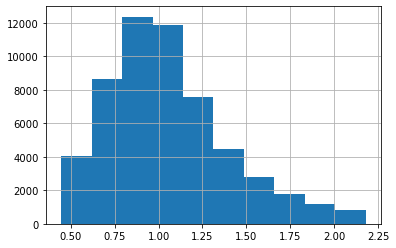

In [19]:
target[(target > target.quantile(0.05)) & (target < target.quantile(0.95))].hist()

<AxesSubplot:>

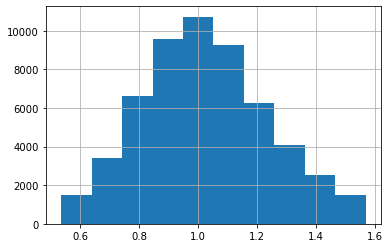

In [20]:
target_sq[(target_sq > target_sq.quantile(0.05)) & (target_sq < target_sq.quantile(0.95))].hist()

In [21]:
target_mask = (target_sq > target_sq.quantile(0.05)) & ( target_sq < target_sq.quantile(0.95))
week_mask = data.week_number > 51

data = data.loc[target_mask & week_mask]
target_sq = target_sq.loc[target_mask & week_mask]

In [22]:
cats = [name for name, type_ in data.dtypes.iteritems() if type_ == 'object']
for cat in cats:
    data[cat] = data[cat].astype('category')

cats = [name for name, type_ in data.dtypes.iteritems() if type_ == 'category']
for cat in cats:
    data[cat] = data[cat].cat.codes
data = data.fillna(-999)

## RandomForest

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(data, target_sq, test_size=0.25)
regr = RandomForestRegressor(random_state=0, n_estimators=4000, max_features = "sqrt") #{“auto”, “sqrt”, “log2”}
regr.fit(train_x, train_y)

pred = regr.predict(val_x)
np.mean(np.abs(((pred-val_y)/val_y)))

0.12356283569800666

In [24]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

main_feats = rf_feat_importance(regr, val_x)

In [27]:
main_feats.to_csv('main_feats.csv')

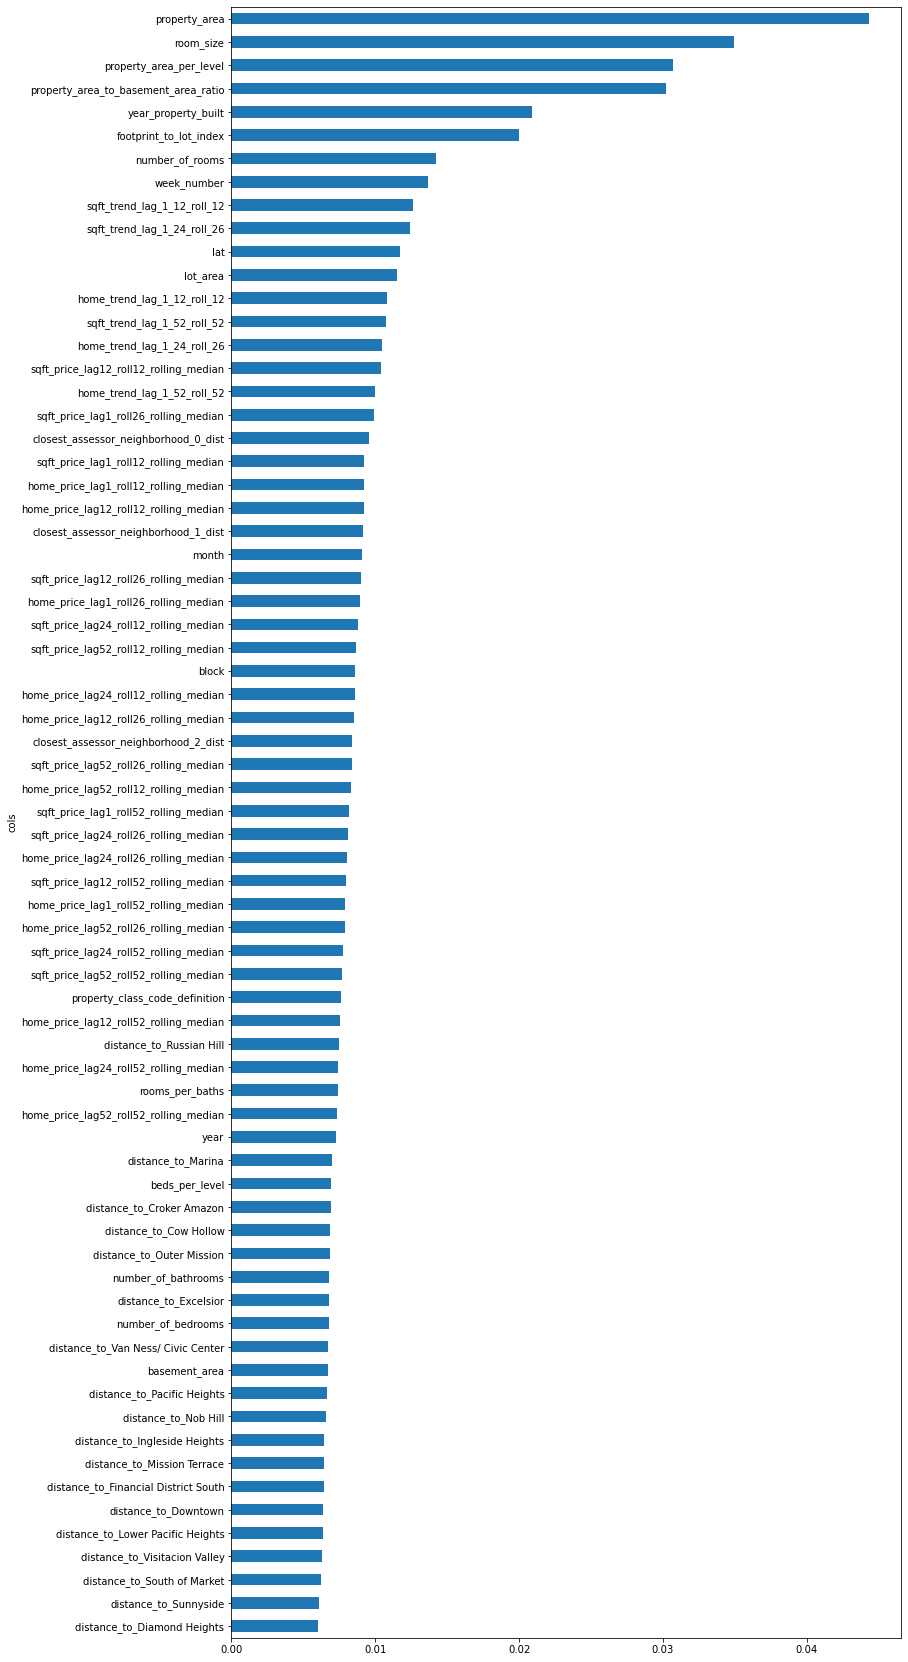

In [25]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,30), legend=False)

plot_fi(main_feats[:70][::-1]);

In [ ]:
stop here

## RF move forward:

In [ ]:
from tqdm import tqdm

In [ ]:
week_number = data.week_number
data = data.drop(columns=['week_number','block'])

In [ ]:
years, week_step = 5, 2

start = 51
end = start + 52*years

number_of_steps = 5
for i in tqdm(range(number_of_steps)):
    
    start = 51 + i*week_step
    end = start + 52*years + i*week_step
    
    train_week_mask = (week_number >= start) & (week_number < end)
    val_week_mask =  (week_number >= end) & (week_number < (end + week_step))

    train_x, val_x = data.loc[train_week_mask], data.loc[val_week_mask]
    train_y, val_y = target_sq.loc[train_week_mask], target_sq.loc[val_week_mask]

    regr = RandomForestRegressor(random_state=0, n_estimators=4000, max_features = "sqrt") #{“auto”, “sqrt”, “log2”}
    regr.fit(train_x, train_y)

    pred = regr.predict(val_x)
    print(f"step {i} mape {np.mean(np.abs(((pred - val_y) / val_y)))}")
    
    models += [regr]

In [ ]:
years, week_step = 5, 2

start = 51
end = start + 52*years

models = list()

number_of_steps = 5
for i in tqdm(range(number_of_steps)):
    
    start = 51 #+ i*week_step
    end = start + 52*years + i*week_step
    
    train_week_mask = (week_number >= start) & (week_number < end)
    val_week_mask =  (week_number >= end) & (week_number < (end + week_step))

    train_x, val_x = data.loc[train_week_mask], data.loc[val_week_mask]
    train_y, val_y = target_sq.loc[train_week_mask], target_sq.loc[val_week_mask]

    regr = RandomForestRegressor(random_state=0, n_estimators=4000, max_features = "sqrt") #{“auto”, “sqrt”, “log2”}
    regr.fit(train_x, train_y)

    pred = regr.predict(val_x)
    print(f"step {i} mape {np.mean(np.abs(((pred - val_y) / val_y)))}")
    
    models += [regr]

### SHAP

In [ ]:
arop here

In [ ]:
import shap

In [ ]:
1+1

In [ ]:
# explainer = shap.Explainer(regr)
# shap_values = explainer(val_x)

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
vals = np.abs(shap_values.values).mean(0)
feature_names = val_x.columns()

feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
feature_importance.head(40)